# setup

In [ ]:
import pandas as pd
from pathlib import Path
from sklearn.model_selection import train_test_split
import numpy as np

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
os.chdir('/content/drive/My Drive/Colab Notebooks/genetic-engineering-attribution-challenge/code/')

In [ ]:
pd.options.display.max_rows = None
pd.options.display.max_columns = None
train_frac = .8
DATA_DIR = Path.cwd().parent / 'data/train_frac_{}'.format(int(train_frac*100))
max_len = 8000

In [ ]:
DATA_DIR

PosixPath('/content/drive/My Drive/Colab Notebooks/genetic-engineering-attribution-challenge/data/train_frac_80')

In [ ]:
# train_values = pd.read_csv(DATA_DIR.parent / 'raw_data/train_values.csv', index_col='sequence_id')
# train_labels = pd.read_csv(DATA_DIR.parent / 'raw_data/train_labels.csv', index_col='sequence_id')
test_values = pd.read_csv(DATA_DIR.parent / 'raw_data/test_values.csv', index_col='sequence_id')

In [ ]:
train_values, val_values, train_labels, val_labels = train_test_split(train_values, train_labels, 
                                              train_size = train_frac, random_state = 0, shuffle = True)

# processing

## keras

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
import tensorflow as tf

In [ ]:
n = 1000
tok = Tokenizer(char_level=True)
tok.fit_on_texts(train_values['sequence'][:n])

In [ ]:
matrix = tok.texts_to_matrix(train_values['sequence'][:n], mode='count')
# X = sequence.pad_sequences(matrix,maxlen=max_len)

In [ ]:
matrix

array([[   0.,  978.,  930., 1101., 1159.,    0.],
       [   0.,  289.,  276.,  217.,  179.,    0.],
       [   0.,  744.,  735.,  837.,  861.,    0.],
       ...,
       [   0., 2215., 2041., 2016., 2051.,    0.],
       [   0., 2087., 2170., 2263., 2508.,    0.],
       [   0.,  155.,  176.,  273.,  294.,    0.]])

In [ ]:
sequences = tok.texts_to_sequences(val_values['sequence'])
X_val = sequence.pad_sequences(sequences,maxlen=max_len)

## look at sequence lengths

In [ ]:
n_samples = train_values.shape[0]
sample_train_values = train_values.iloc[:n_samples,:]

In [ ]:
del train_values

In [ ]:
sequence_lengths = sample_train_values.sequence.apply(len)
sequence_lengths.describe([.4, .5,.75,.9,.95])

In [ ]:
(8000*.2*50413+3000*.8*50413)/(4840*50413)

0.8264462809917356

## convert sequences

In [ ]:
nucleotide_dict = {'A': [1,0,0,0,0],
           'C': [0,1,0,0,0],
           'G': [0,0,1,0,0],
           'N': [0,0,0,1,0],
           'T': [0,0,0,0,1],
            0:  [0,0,0,0,0]}

In [ ]:
pad_list = [0] * max_len
def convert_sequence(sequence, max_len=max_len):
    
    seq_len = len(sequence)
    if seq_len > max_len:
        sequence = list(sequence)[:max_len]
    else:
        sequence = list(sequence) + pad_list[:(max_len - seq_len)]
        # sequence = list(sequence) * int((max_len / seq_len) + 1)
        sequence = sequence[:max_len]
        
    sequence = list(map(nucleotide_dict.get, sequence)) #[nucleotide_dict[nuc] for nuc in sequence]
    return sequence

In [ ]:
sample_train_values = sample_train_values['sequence']
X = np.array([convert_sequence(seq) for seq in sample_train_values])
X.shape

In [ ]:
del sample_train_values

In [ ]:
val_values = val_values['sequence']
X_val = np.array([convert_sequence(seq) for seq in val_values])
X_val.shape

In [ ]:
del val_values

In [ ]:
X_test = np.array([convert_sequence(seq) for seq in test_values['sequence']])
X_test.shape

In [ ]:
del test_values

## variables for ml

### reshape

In [ ]:
X = np.reshape(X, (X.shape[0], X.shape[1], 1, X.shape[2]))
X.shape

In [ ]:
X_val = np.reshape(X_val, (X_val.shape[0], X_val.shape[1], 1, X_val.shape[2]))
X_val.shape

In [ ]:
y = train_labels.iloc[:n_samples,:]
y = np.array(y)
y.shape

(59866, 1314)

In [ ]:
del train_labels

In [ ]:
y_val = np.array(val_labels)
y_val.shape

(3151, 1314)

In [ ]:
del val_labels

In [ ]:
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1, X_test.shape[2]))

### save and load

In [ ]:
np.save("{}/X_cnn".format(DATA_DIR), X)

In [ ]:
np.save("{}/X_val_cnn".format(DATA_DIR), X_val)

In [ ]:
np.save("{}/X_test_cnn".format(DATA_DIR), X_test)

In [ ]:
X = np.load("{}/X_cnn.npy".format(DATA_DIR))
X.shape

(50413, 9000, 1, 5)

In [ ]:
X = np.reshape(X, (X.shape[0], X.shape[1], X.shape[3], 1))

In [ ]:
X_val = np.load("{}/X_val_cnn.npy".format(DATA_DIR))
X_val.shape

(12604, 9000, 1, 5)

In [ ]:
X_val = np.reshape(X_val, (X_val.shape[0], X_val.shape[1], X_val.shape[3], 1))

In [ ]:
X_test = np.load("{}/X_test_cnn.npy".format(DATA_DIR))
X_test.shape

(18816, 7000, 1, 5)

In [ ]:
!pip install datatable

     |████████████████████████████████| 83.7MB 1.2MB/s 


In [ ]:
import datatable as dt
y = dt.fread(DATA_DIR / 'y.csv')#, max_nrows=30000)
y = y.to_numpy()
y_val = dt.fread(DATA_DIR / 'y_val.csv')#, max_nrows=3000)
y_val = y_val.to_numpy()

ValueError: ignored

In [ ]:
print(y.shape)
print(y_val.shape)

(59866, 1314)
(3151, 1314)


# model

## libraries

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, BatchNormalization, Flatten, Dropout, GlobalMaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.backend import clear_session
# from tensorflow.python.framework import ops
# from imblearn.over_sampling import RandomOverSampler
from tensorflow.keras.metrics import TopKCategoricalAccuracy
# from sklearn.metrics import accuracy_score, auc, roc_auc_score, confusion_matrix
# from tensorflow.keras.utils import plot_model
# from keras.layers.merge import concatenate
# from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.random import set_seed
import tensorflow as tf
# from tensorflow.keras import initializers
# from tensorflow.keras.activations import relu, sigmoid

In [ ]:
top_10_accuracy = TopKCategoricalAccuracy(k=10)

## custom loss function

In [ ]:
def my_loss_fn(y_true, y_pred):
    cce = tf.keras.losses.CategoricalCrossentropy(reduction=tf.keras.losses.Reduction.NONE)
    cce_tensor = cce(y_true, y_pred)
    tf.print(cce_tensor)
    return tf.reduce_mean(cce_tensor)  # Note the `axis=-1`

In [ ]:
y_true = [[0, 1, 0], [0, 0, 1]] 
y_pred = [[0.05, 0.95, 0], [0.1, 0.8, 0.1]]
my_loss_fn(y_true, y_pred)

2.3538785


<tf.Tensor: shape=(), dtype=float32, numpy=2.3538785>

In [ ]:
@tf.function
def top10_accuracy_scorer(y_true, y_pred, from_logits=False):

    values, indeces = tf.math.top_k(y_pred, 10)
    lab_indeces_tensor = tf.argmax(y_true,1)
    lab_indeces_tensor = tf.reshape(lab_indeces_tensor, 
                                    shape=(tf.shape(lab_indeces_tensor)[0],1))
    lab_indeces_tensor = tf.dtypes.cast(lab_indeces_tensor,dtype=tf.int32)
    equal_tensor = tf.equal(lab_indeces_tensor, indeces)
    
    sum_tensor = tf.reduce_sum(tf.cast(equal_tensor, tf.float32))
    top10_accuracy = sum_tensor/tf.cast(tf.shape(lab_indeces_tensor)[0], tf.float32)
    
    return top10_accuracy

In [ ]:
X_temp = np.random.uniform(0,1,(1000,100))
y_temp = np.random.uniform(0,1,(1000,10))
y_temp = np.argmax(y_temp, axis=1)
y_temp = tf.keras.utils.to_categorical(y_temp)

In [ ]:
model = Sequential()
model.add(Dense(y_temp.shape[1], input_shape = (X_temp.shape[1],), activation='softmax'))
model.compile(optimizer='adam',
              loss='categorical_crossentropy',#top10_accuracy_scorer,
              metrics=['accuracy'])
model.fit(X_temp, y_temp)

32/32 [==============================] - 0s 2ms/step - loss: 2.3984 - accuracy: 0.1030


## single model

### 95% training

In [ ]:
# n_rows_concat = 9000
# X = np.concatenate([X, X_val[:n_rows_concat,:]], axis=0)
# X_val = X_val[n_rows_concat:,:]
# print(X.shape)

In [ ]:
# y = np.concatenate([y, y_val[:n_rows_concat,:]], axis=0)
# print(y.shape)
# y_val = y_val[n_rows_concat:,:]

### build model

In [ ]:
# Trial summary
# |-Trial ID: a6e0b925bab26dc0c206a75ff966f052
# |-Score: 0.8893208503723145
# |-Best step: 0
# Hyperparameters:
# |-activation_function_1: relu
# |-activation_function_3: sigmoid
# |-batch_normalization_1: True
# |-batch_size: 128
# |-dropout_1: False
# |-dropout_1=True/rate_1: 0.006033511656319794
# |-hidden_layer_size: 982
# |-kernel_size_1: 18
# |-num_filters_1: 224
# |-tuner/bracket: 2
# |-tuner/epochs: 25
# |-tuner/initial_epoch: 9
# |-tuner/round: 2
# |-tuner/trial_id: 5da2a10a85744eaf718b167c03e8eb95

In [ ]:
clear_session()
set_seed(0)
model = Sequential()
model.add(Conv2D(224, (8, 5), strides=(1,1), input_shape = (max_len, 5, 1), activation = 'relu'))
# model.add(GlobalMaxPooling2D())
model.add(GlobalAveragePooling2D())
# model.add(MaxPooling2D(pool_size = (16, 1), strides=(8,1)))
model.add(BatchNormalization())
# model.add(Dropout(0.8))

# model.add(Conv2D(64, (4, 1), activation = 'relu'))
# model.add(MaxPooling2D(pool_size = (4, 1)))
# model.add(BatchNormalization())
# model.add(Dropout(.3))

model.add(Flatten())

model.add(Dense(500, activation = 'sigmoid'))

model.add(Dense(y.shape[1], activation = 'softmax'))

# learning_rate = 0.0008260715348075374
# beta_1 = 1 - 0.006917519049505885
# beta_2 = 1 - 1.4159416168842825e-05
model.compile(loss='categorical_crossentropy',
              optimizer=Adam(),
              metrics=[top_10_accuracy])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 7993, 1, 224)      9184      
_________________________________________________________________
global_average_pooling2d (Gl (None, 224)               0         
_________________________________________________________________
batch_normalization (BatchNo (None, 224)               896       
_________________________________________________________________
flatten (Flatten)            (None, 224)               0         
_________________________________________________________________
dense (Dense)                (None, 500)               112500    
_________________________________________________________________
dense_1 (Dense)              (None, 1314)              658314    
Total params: 780,894
Trainable params: 780,446
Non-trainable params: 448
________________________________________________

In [ ]:
callback = EarlyStopping(monitor='val_top_k_categorical_accuracy', patience=2)

model.fit(X, y,
          batch_size = 64,
          epochs=25, 
          verbose=1, 
          validation_data=(X_val, y_val), 
          callbacks=[callback])

Epoch 1/25


ValueError: ignored

### save model and outputs

In [ ]:
#0.8965, max_len = 8000, 95%
from datetime import datetime
timestamp = datetime.now().strftime("%d-%m-%Y %H_%M_%S")

model.save('{}/models/latest_cnn_model'.format(DATA_DIR))
model.save('{}/models/{}_cnn_model'.format(DATA_DIR, timestamp))

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: /content/drive/My Drive/Colab Notebooks/genetic-engineering-attribution-challenge/data/train_frac_95/models/latest_cnn_model/assets
INFO:tensorflow:Assets written to: /content/drive/My Drive/Colab Notebooks/genetic-engineering-attribution-challenge/data/train_frac_95/models/18-09-2020 16_28_24_cnn_model/assets


In [ ]:
import tensorflow as tf
model = tf.keras.models.load_model('{}/models/latest_cnn_model'.format(DATA_DIR),
                                               compile=True)

In [ ]:
y_probs = model.predict_proba(X)
y_val_probs = model.predict_proba(X_val)


Instructions for updating:
Please use `model.predict()` instead.


In [ ]:
np.savetxt("{}/y_probs_cnn.csv".format(DATA_DIR), y_probs, delimiter=",")
np.savetxt("{}/y_val_probs_cnn.csv".format(DATA_DIR), y_val_probs, delimiter=",")


In [ ]:
# X_test = np.load("{}/X_test_cnn.npy".format(DATA_DIR))
print(X_test.shape)
y_test_probs = model.predict_proba(X_test)
np.savetxt("{}/y_test_probs_cnn.csv".format(DATA_DIR), y_test_probs, delimiter=",")

(18816, 8000, 1, 5)
Instructions for updating:
Please use `model.predict()` instead.


## build model

In [ ]:
def build_model(hp):
  
    #  'optimizer': [Adam, Nadam, RMSprop],
    
    clear_session()
    set_seed(0)

    model = Sequential()

    kernel_size_1 = hp.Int('kernel_size_1', 8, 64)
    
    strides_1 = hp.Int('strides_1', 2, 6)
    num_filters_1 = hp.Int('num_filters_1', 32, 384*strides_1, step=32)
    activation_function_1 = hp.Choice('activation_function_1', ['relu','tanh','sigmoid'])

    model.add(Conv2D(num_filters_1, (kernel_size_1, 5), strides=(strides_1, 1), input_shape = (max_len, 5, 1), activation = activation_function_1))

    GlobalMaxPooling2D_1 = hp.Choice('GlobalMaxPooling2D_1',['max','avg','local','layer_2']) #GlobalAveragePooling2D
    if GlobalMaxPooling2D_1 == 'max':
      model.add(GlobalMaxPooling2D())

    elif GlobalMaxPooling2D_1 == 'avg':
      model.add(GlobalAveragePooling2D())

    elif GlobalMaxPooling2D_1 == 'local':
      with hp.conditional_scope('GlobalMaxPooling2D_1', 'local'):
        pool_size_1 = hp.Int('pool_size_1', 2, 12)
        model.add(MaxPooling2D(pool_size = (pool_size_1, 1)))

    elif GlobalMaxPooling2D_1 == 'layer_2':
      with hp.conditional_scope('GlobalMaxPooling2D_1', 'layer_2'):
        model.add(GlobalMaxPooling2D())
        # pool_size_1_layer_2 = hp.Int('pool_size_1_layer_2', 2, 12)
        # model.add(MaxPooling2D(pool_size = (pool_size_1_layer_2, 1)))

    if hp.Boolean('batch_normalization_1'):
      model.add(BatchNormalization())

    if hp.Boolean('dropout_1'):
      with hp.conditional_scope('dropout_1', True):
        rate_1 = hp.Float('rate_1',.001,.5,sampling='log')
        model.add(Dropout(rate_1))

    # if GlobalMaxPooling2D_1 == 'layer_2':
    #   with hp.conditional_scope('GlobalMaxPooling2D_1', 'layer_2'):

    #     kernel_size_2 = hp.Int('kernel_size_2', 2, 24)
    #     num_filters_2 = hp.Int('num_filters_2', 32, 256, step=32)
    #     activation_function_2 = hp.Choice('activation_function', ['relu','tanh','sigmoid'])

    #     model.add(Conv2D(num_filters_2, (kernel_size_2, 1), activation = activation_function_2))

    #     if hp.Boolean('GlobalMaxPooling2D_2'):
    #       model.add(GlobalMaxPooling2D())
    #     else:
    #       with hp.conditional_scope('GlobalMaxPooling2D_2', False):
    #         pool_size_2 = hp.Int('pool_size_2', 2, 12)
    #         model.add(MaxPooling2D(pool_size = (pool_size_2, 1)))

    #     if hp.Boolean('batch_normalization_2'):
    #       model.add(BatchNormalization())

    #     if hp.Boolean('dropout_2'):
    #       rate = hp.Float('rate',.001,.5,sampling='log')
    #       model.add(Dropout(rate))

        
    model.add(Flatten())

    hidden_layer_size = hp.Int('hidden_layer_size', 30, 1000)
    activation_function_3 = hp.Choice('activation_function_3', ['relu','tanh','sigmoid'])

    model.add(Dense(hidden_layer_size, activation = activation_function_3))

    model.add(Dense(y.shape[1], activation = 'softmax'))

    # learning_rate = hp.Float('learning_rate', .00001,.1,sampling='log')
    # beta_1 = 1 - hp.Float('one_minus_beta_1', .001, .2,sampling='log')
    # beta_2 = 1 - hp.Float('one_minus_beta_2', .00001, .02,sampling='log')

    model.compile(loss='categorical_crossentropy',
                  optimizer=Adam(),#Adam(learning_rate, beta_1, beta_2),
                  metrics=[top_10_accuracy])
    
    
    return model

## tuning

In [ ]:
!pip install -U keras-tuner

     |████████████████████████████████| 61kB 2.8MB/s 
  Created wheel for keras-tuner: filename=keras_tuner-1.0.1-cp36-none-any.whl size=73200 sha256=95bab0e2bb8fe4bff08254e708c9fc0600e31d97a1f5c78310f308145b5a412f
  Stored in directory: /root/.cache/pip/wheels/b9/cc/62/52716b70dd90f3db12519233c3a93a5360bc672da1a10ded43
  Created wheel for terminaltables: filename=terminaltables-3.1.0-cp36-none-any.whl size=15356 sha256=2e0021ca5e0f4314cae6c328cf65a9f0159f65f5cad0b5f8bf589b4603cf8940
  Stored in directory: /root/.cache/pip/wheels/30/6b/50/6c75775b681fb36cdfac7f19799888ef9d8813aff9e379663e
Successfully built keras-tuner terminaltables


In [ ]:
# import kerastuner as kt
from kerastuner import Objective
from kerastuner.tuners import Hyperband

class MyTuner(Hyperband):
  def run_trial(self, trial, *args, **kwargs):
    # You can add additional HyperParameters for preprocessing and custom training loops
    # via overriding `run_trial`
    kwargs['batch_size'] = trial.hyperparameters.Int('batch_size', 32, 256, step=32)

    super(MyTuner, self).run_trial(trial, *args, **kwargs)

# Uses same argments as the BayesianOptimization Tuner.
tuner = MyTuner(
    build_model,
    objective=Objective('val_top_k_categorical_accuracy', 'max'),
    max_epochs=25,
    factor=2,
    hyperband_iterations=2,
    seed = 0,
    # distribution_strategy=tf.distribute.MirroredStrategy(),
    directory='tuning',
    project_name='cnn',
    overwrite=True)

callback = EarlyStopping(monitor='val_top_k_categorical_accuracy', patience=2)

tuner.search(X, y,
             validation_data=(X_val, y_val),
             verbose=0,
             callbacks=[callback])

In [ ]:
#8000 features
Trial summary
|-Trial ID: 0a05b71f77ffb20bc7b742bd47fee498
|-Score: 0.8962234258651733
|-Best step: 0
Hyperparameters:
|-activation_function_1: sigmoid
|-activation_function_3: sigmoid
|-batch_normalization_1: True
|-batch_size: 128
|-dropout_1: True
|-dropout_1=True/rate_1: 0.07596708419037249
|-hidden_layer_size: 880
|-kernel_size_1: 23
|-num_filters_1: 352
|-tuner/bracket: 2
|-tuner/epochs: 25
|-tuner/initial_epoch: 13
|-tuner/round: 2
|-tuner/trial_id: 29e356eecc26623cacd39566f35159a7

#8000 features
Trial summary
|-Trial ID: e465121b5d2d1e5cb2b962285d92c2ca
|-Score: 0.8921771049499512
|-Best step: 0
Hyperparameters:
|-activation_function_1: tanh
|-activation_function_3: sigmoid
|-batch_normalization_1: True
|-batch_size: 64
|-dropout_1: True
|-dropout_1=True/rate_1: 0.0028678661796817054
|-hidden_layer_size: 916
|-kernel_size_1: 22
|-num_filters_1: 256
|-tuner/bracket: 0
|-tuner/epochs: 25
|-tuner/initial_epoch: 0
|-tuner/round: 0

Trial summary
|-Trial ID: a6e0b925bab26dc0c206a75ff966f052
|-Score: 0.8893208503723145
|-Best step: 0
Hyperparameters:
|-activation_function_1: relu
|-activation_function_3: sigmoid
|-batch_normalization_1: True
|-batch_size: 128
|-dropout_1: False
|-dropout_1=True/rate_1: 0.006033511656319794
|-hidden_layer_size: 982
|-kernel_size_1: 18
|-num_filters_1: 224
|-tuner/bracket: 2
|-tuner/epochs: 25
|-tuner/initial_epoch: 9
|-tuner/round: 2
|-tuner/trial_id: 5da2a10a85744eaf718b167c03e8eb95

Trial summary
|-Trial ID: 04e47177fabc0fb927a016bd0432322a
|-Score: 0.8864645957946777
|-Best step: 0
Hyperparameters:
|-activation_function_1: sigmoid
|-activation_function_3: relu
|-batch_normalization_1: True
|-batch_size: 96
|-dropout_1: False
|-dropout_1=True/rate_1: 0.16994373431147772
|-hidden_layer_size: 967
|-kernel_size_1: 49
|-num_filters_1: 288
|-tuner/bracket: 2
|-tuner/epochs: 25
|-tuner/initial_epoch: 9
|-tuner/round: 2
|-tuner/trial_id: 8fedcc331636e80a7126307aa37e68ad

Trial summary
|-Trial ID: 8fedcc331636e80a7126307aa37e68ad
|-Score: 0.8833703398704529
|-Best step: 0
Hyperparameters:
|-activation_function_1: sigmoid
|-activation_function_3: relu
|-batch_normalization_1: True
|-batch_size: 96
|-dropout_1: False
|-dropout_1=True/rate_1: 0.16994373431147772
|-hidden_layer_size: 967
|-kernel_size_1: 49
|-num_filters_1: 288
|-tuner/bracket: 2
|-tuner/epochs: 9
|-tuner/initial_epoch: 3
|-tuner/round: 1
|-tuner/trial_id: 6964c2c40d0a53a85c35bcda2ad8d794

Trial summary
|-Trial ID: 18d6119fc55c5cedf6d7063a98297789
|-Score: 0.8736909031867981
|-Best step: 0
Hyperparameters:
|-activation_function_1: sigmoid
|-activation_function_3: tanh
|-batch_normalization_1: True
|-batch_size: 96
|-dropout_1: False
|-dropout_1=True/rate_1: 0.0011259189415113527
|-hidden_layer_size: 747
|-kernel_size_1: 32
|-num_filters_1: 160
|-tuner/bracket: 2
|-tuner/epochs: 25
|-tuner/initial_epoch: 9
|-tuner/round: 2
|-tuner/trial_id: 26b2f9b2a7b316e01a9c08464341a8a0

1809580032

In [ ]:
models = tuner.get_best_models(num_models=5)
tuner.results_summary()

In [ ]:
for i in range(len(models)):
    model = models[i]
    model.save('{}/models/best_model_cnn_{}'.format(DATA_DIR, i))

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: /content/drive/My Drive/Colab Notebooks/genetic-engineering-attribution-challenge/data/train_frac_80/models/best_model_cnn_0/assets
INFO:tensorflow:Assets written to: /content/drive/My Drive/Colab Notebooks/genetic-engineering-attribution-challenge/data/train_frac_80/models/best_model_cnn_1/assets
INFO:tensorflow:Assets written to: /content/drive/My Drive/Colab Notebooks/genetic-engineering-attribution-challenge/data/train_frac_80/models/best_model_cnn_2/assets
INFO:tensorflow:Assets written to: /content/drive/My Drive/Colab Notebooks/genetic-engineering-attribution-challenge/data/train_frac_80/models/best_model_cnn_3/assets
INFO:tensorflow:Assets written to: /content/drive/My Drive/Colab Notebooks/genetic-engineering-att

## parallel cnn

### single model

In [ ]:
# Trial summary
# |-Trial ID: c079800e05a3fe2629938d8fe2665cbb
# |-Score: 0.8982862830162048
# |-Best step: 0
# Hyperparameters:
# |-activation_function: sigmoid
# |-batch_normalization: True
# |-batch_size: 192
# |-dropout: True
# |-dropout=True/rate: 0.013878301620179912
# |-hidden_layer_size: 1390
# |-kernel_initializer_1: glorot_uniform
# |-kernel_size_0: 54
# |-kernel_size_1: 50
# |-kernel_size_2: 40
# |-num_filters_1: 224
# |-pooling_1: max
# |-pooling_1=local_max/max_pool_size_0: 29
# |-pooling_1=local_max/max_pool_size_1: 11
# |-pooling_1=local_max/max_pool_size_2: 15
# |-tuner/bracket: 4
# |-tuner/epochs: 25
# |-tuner/initial_epoch: 13
# |-tuner/round: 3
# |-tuner/trial_id: 626c527b2df1abd56d59aca272d47085

In [ ]:
from tensorflow.keras.utils import plot_model
from tensorflow.random import set_seed
import tensorflow as tf

In [ ]:
# variable initialization 
from keras import Input, Model, Sequential
from keras.layers import Conv2D, MaxPooling2D, Concatenate, Activation, Dropout, Flatten, Dense, GlobalMaxPool2D

clear_session()
set_seed(0)

nb_filters = 224
kernel_size= {}
# kernel_size[0]= [2,1]
# kernel_size[1]= [4,1]
# kernel_size[2]= [8,1]
kernel_size[0]= [54,1]
kernel_size[1]= [50,1]
kernel_size[2]= [40,1]

strides = {}
strides[0] = (2,1)
strides[1] = (4,1)
strides[2] = (8,1)
input_shape=(max_len, 1, 5)
pool_size = (2,1)

inp = Input(shape=input_shape)
convs = []
for k_no in range(len(kernel_size)):
    conv = Conv2D(nb_filters,  
                  (kernel_size[k_no][0], kernel_size[k_no][1]),
                  kernel_initializer='glorot_uniform',
                  # strides=(2,1),#strides[k_no],
                  activation='sigmoid')(inp)
    # pool = MaxPooling2D(pool_size=pool_size)(conv)
    # conv = Conv2D(nb_filters,  
    #               (kernel_size[k_no][0], kernel_size[k_no][1]),
    #               # strides=strides[k_no],
    #               activation='relu')(pool)
    pool = GlobalMaxPool2D()(conv)


    convs.append(pool)

if len(kernel_size) > 1:
    out = Concatenate()(convs)
else:
    out = convs[0]

conv_model = Model(inputs=inp, outputs=out)

# add created model grapg in sequential model
model = Sequential()
model.add(conv_model)        # add model just like layer

model.add(Flatten())

model.add(BatchNormalization())
model.add(Dropout(0.013878301620179912))

model.add(Dense(1390, activation = 'sigmoid'))
model.add(Dense(y.shape[1], activation = 'softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer=Adam(),
              metrics=[top_10_accuracy])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
functional_1 (Functional)    (None, 672)               161952    
_________________________________________________________________
flatten (Flatten)            (None, 672)               0         
_________________________________________________________________
batch_normalization (BatchNo (None, 672)               2688      
_________________________________________________________________
dropout (Dropout)            (None, 672)               0         
_________________________________________________________________
dense (Dense)                (None, 1390)              935470    
_________________________________________________________________
dense_1 (Dense)              (None, 1314)              1827774   
Total params: 2,927,884
Trainable params: 2,926,540
Non-trainable params: 1,344
__________________________________________

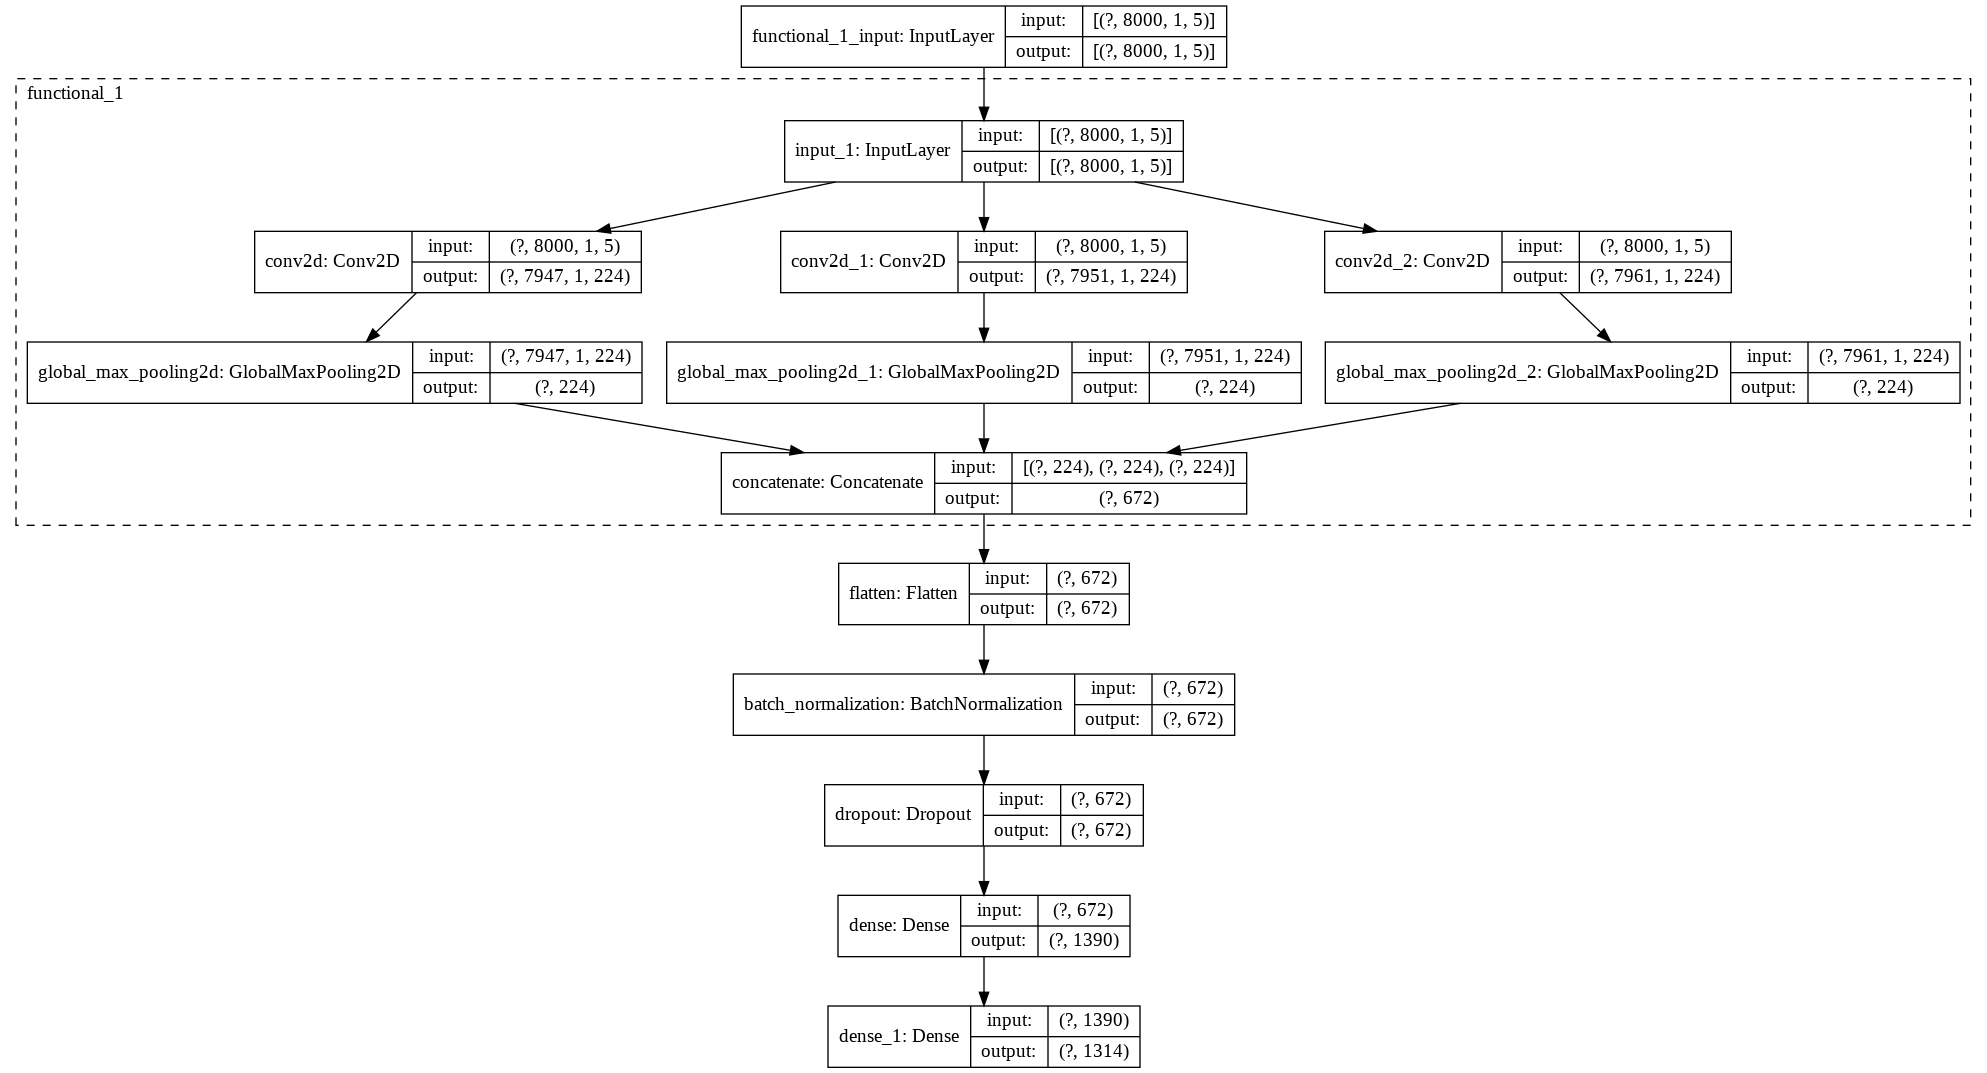

In [ ]:
plot_model(model, show_shapes=True, expand_nested=True)

In [ ]:
callback = EarlyStopping(monitor='val_top_k_categorical_accuracy', patience=5)

model.fit(X, y,
          batch_size = 192,
          epochs=50, 
          verbose=1, 
          validation_data=(X_val, y_val), 
          callbacks=[callback])

Epoch 1/50
312/312 [==============================] - 65s 209ms/step - loss: 3.7650 - top_k_categorical_accuracy: 0.6004 - val_loss: 4.5811 - val_top_k_categorical_accuracy: 0.5881
Epoch 2/50
312/312 [==============================] - 64s 206ms/step - loss: 2.1220 - top_k_categorical_accuracy: 0.8065 - val_loss: 2.0377 - val_top_k_categorical_accuracy: 0.8258
Epoch 3/50
312/312 [==============================] - 64s 206ms/step - loss: 1.4089 - top_k_categorical_accuracy: 0.8925 - val_loss: 1.5985 - val_top_k_categorical_accuracy: 0.8639
Epoch 4/50
312/312 [==============================] - 64s 207ms/step - loss: 0.9569 - top_k_categorical_accuracy: 0.9426 - val_loss: 1.4380 - val_top_k_categorical_accuracy: 0.8858
Epoch 5/50
312/312 [==============================] - 64s 206ms/step - loss: 0.6544 - top_k_categorical_accuracy: 0.9737 - val_loss: 1.3689 - val_top_k_categorical_accuracy: 0.8937
Epoch 6/50
312/312 [==============================] - 64s 206ms/step - loss: 0.4413 - top_k_cat

### save model and outputs

In [ ]:
#0.9032
from datetime import datetime
timestamp = datetime.now().strftime("%d-%m-%Y %H_%M_%S")

model.save('{}/models/latest_cnn_model'.format(DATA_DIR))
model.save('{}/models/{}_cnn_model'.format(DATA_DIR, timestamp))

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: /content/drive/My Drive/Colab Notebooks/genetic-engineering-attribution-challenge/data/train_frac_95/models/latest_cnn_model/assets
INFO:tensorflow:Assets written to: /content/drive/My Drive/Colab Notebooks/genetic-engineering-attribution-challenge/data/train_frac_95/models/25-09-2020 03_20_52_cnn_model/assets


In [ ]:
import tensorflow as tf
model = tf.keras.models.load_model('{}/models/latest_cnn_model'.format(DATA_DIR),
                                               compile=True)

In [ ]:
y_probs = model.predict_proba(X)
y_val_probs = model.predict_proba(X_val)


Instructions for updating:
Please use `model.predict()` instead.


In [ ]:
np.savetxt("{}/y_probs_cnn.csv".format(DATA_DIR), y_probs, delimiter=",")
np.savetxt("{}/y_val_probs_cnn.csv".format(DATA_DIR), y_val_probs, delimiter=",")


In [ ]:
train_frac = .8
DATA_DIR = Path.cwd().parent / 'data/train_frac_{}'.format(int(train_frac*100))
X_test = np.load("{}/X_test_cnn.npy".format(DATA_DIR))
print(X_test.shape)


(18816, 8000, 1, 5)


In [ ]:
train_frac = .95
DATA_DIR = Path.cwd().parent / 'data/train_frac_{}'.format(int(train_frac*100))
y_test_probs = model.predict_proba(X_test)
np.savetxt("{}/y_test_probs_cnn.csv".format(DATA_DIR), y_test_probs, delimiter=",")

Instructions for updating:
Please use `model.predict()` instead.


### build model for tuning

In [ ]:
!pip install -U keras-tuner

Requirement already up-to-date: keras-tuner in /usr/local/lib/python3.6/dist-packages (1.0.1)


In [ ]:
# variable initialization 
from keras import Input, Model, Sequential
from keras.layers import Conv2D, Concatenate, Activation, Dropout, Flatten, Dense, GlobalMaxPool2D, GlobalAvgPool2D, MaxPool2D, AvgPool2D
from tensorflow.random import set_seed

def build_model(hp):

  clear_session()
  set_seed(0)

  num_filters_1 = hp.Int('num_filters_1', 32, 300, step=32)
  kernel_size= {}
  n_kernels = 3
  kernel_size_range = [2, 64]
  for i in range(n_kernels):
    kernel_size_i = hp.Int('kernel_size_{}'.format(i), kernel_size_range[0], kernel_size_range[1], step = 2)
    kernel_size[i] = [kernel_size_i, 1]

  input_shape=(max_len, 1, 5)

  # create seperate model graph for parallel processing with different filter sizes
  # apply 'same' padding so that ll produce o/p tensor of same size for concatination
  # cancat all paralle output

  inp = Input(shape=input_shape)
  convs = []

  pooling_1 = hp.Choice('pooling_1',['max','local_max'])
  activation_function_1 = hp.Choice('activation_function', ['relu','tanh','sigmoid'])
  initializer = hp.Choice('kernel_initializer_{}'.format('1'), 
                                     ['random_normal', 'random_uniform', 'glorot_normal', 'glorot_uniform', 'ones', 'zeros'])

  for k_no in range(n_kernels):
      conv = Conv2D(num_filters_1,  
                    (kernel_size[k_no][0], kernel_size[k_no][1]), 
                    activation=activation_function_1,
                    kernel_initializer=initializer)(inp)

      if pooling_1 == 'max':
        pool = GlobalMaxPool2D()(conv)
      # elif pooling_1 == 'avg':
      #   pool = GlobalAvgPool2D()(conv)
      elif pooling_1 == 'local_max':
        with hp.conditional_scope('pooling_1', 'local_max'):

          pool_size = hp.Int('max_pool_size_{}'.format(k_no), 1, 32)
          pool = MaxPool2D(pool_size=(pool_size, 1))(conv)

          conv = Conv2D(num_filters_1,  
                    (kernel_size[k_no][0], kernel_size[k_no][1]), 
                    activation=activation_function_1,
                    kernel_initializer=initializer)(pool)

          pool = GlobalMaxPool2D()(conv)
      # elif pooling_1 == 'local_avg':
      #   with hp.conditional_scope('pooling_1', 'local_avg'):
      #     pool_size = hp.Int('avg_pool_size_{}'.format(k_no), 1, 32)
      #     pool = AvgPool2D(pool_size)(conv)


      convs.append(pool)

  if n_kernels > 1:
      out = Concatenate()(convs)
  else:
      out = convs[0]

  conv_model = Model(inputs=inp, outputs=out)

  # add created model grapg in sequential model

  model = Sequential()
  model.add(conv_model)        # add model just like layer
 
  model.add(Flatten())

  if hp.Boolean('batch_normalization'):
    model.add(BatchNormalization())

  if hp.Boolean('dropout'):
      with hp.conditional_scope('dropout', True):
        rate = hp.Float('rate',.001,.5,sampling='log')
        model.add(Dropout(rate))

  hidden_layer_size = hp.Int('hidden_layer_size', 50, 1500,sampling='log')
  activation_function = hp.Choice('activation_function', ['relu','tanh','sigmoid'])

  model.add(Dense(hidden_layer_size, activation = activation_function))

  model.add(Dense(y.shape[1], activation = 'softmax'))

  model.compile(loss='categorical_crossentropy',
                optimizer=Adam(),
                metrics=[top_10_accuracy])
  
  return model


### tune

In [ ]:
!pip install -U keras-tuner

Requirement already up-to-date: keras-tuner in /usr/local/lib/python3.6/dist-packages (1.0.1)


In [ ]:
# import kerastuner as kt
from kerastuner import Objective
from kerastuner.tuners import Hyperband

class MyTuner(Hyperband):
  def run_trial(self, trial, *args, **kwargs):
    # You can add additional HyperParameters for preprocessing and custom training loops
    # via overriding `run_trial`
    kwargs['batch_size'] = trial.hyperparameters.Int('batch_size', 32, 224, step=32)

    super(MyTuner, self).run_trial(trial, *args, **kwargs)

# Uses same argments as the BayesianOptimization Tuner.
tuner = MyTuner(
    build_model,
    objective=Objective('val_top_k_categorical_accuracy', 'max'),
    max_epochs=50,
    factor=2,
    hyperband_iterations=2,
    seed = 0,
    # distribution_strategy=tf.distribute.MirroredStrategy(),
    directory='tuning',
    project_name='cnn',
    overwrite=True)

callback = EarlyStopping(monitor='val_top_k_categorical_accuracy', patience=5)

tuner.search(X, y,
             validation_data=(X_val, y_val),
             verbose=0f,
             callbacks=[callback])

KeyboardInterrupt: ignored

In [ ]:
Trial summary
|-Trial ID: c079800e05a3fe2629938d8fe2665cbb
|-Score: 0.8982862830162048
|-Best step: 0
Hyperparameters:
|-activation_function: sigmoid
|-batch_normalization: True
|-batch_size: 192
|-dropout: True
|-dropout=True/rate: 0.013878301620179912
|-hidden_layer_size: 1390
|-kernel_initializer_1: glorot_uniform
|-kernel_size_0: 54
|-kernel_size_1: 50
|-kernel_size_2: 40
|-num_filters_1: 224
|-pooling_1: max
|-pooling_1=local_max/max_pool_size_0: 29
|-pooling_1=local_max/max_pool_size_1: 11
|-pooling_1=local_max/max_pool_size_2: 15
|-tuner/bracket: 4
|-tuner/epochs: 25
|-tuner/initial_epoch: 13
|-tuner/round: 3
|-tuner/trial_id: 626c527b2df1abd56d59aca272d47085

Trial summary
|-Trial ID: 25e3eb2e9a8ad2d7a245ca57cc063725
|-Score: 0.898127555847168
|-Best step: 0
Hyperparameters:
|-activation_function: sigmoid
|-batch_normalization: True
|-batch_size: 192
|-dropout: True
|-dropout=True/rate: 0.013878301620179912
|-hidden_layer_size: 1390
|-kernel_initializer_1: glorot_uniform
|-kernel_size_0: 54
|-kernel_size_1: 50
|-kernel_size_2: 40
|-num_filters_1: 224
|-pooling_1: max
|-pooling_1=local_max/max_pool_size_0: 29
|-pooling_1=local_max/max_pool_size_1: 11
|-pooling_1=local_max/max_pool_size_2: 15
|-tuner/bracket: 4
|-tuner/epochs: 50
|-tuner/initial_epoch: 25
|-tuner/round: 4
|-tuner/trial_id: c079800e05a3fe2629938d8fe2665cbb

## other models

In [ ]:
from keras.preprocessing.sequence import pad_sequences
from keras.layers import LSTM
In [ ]:
maxlen = 100

X_train_pad = pad_sequences(X_train, maxlen=maxlen)
X_test_pad = pad_sequences(X_test, maxlen=maxlen)
In [ ]:
X_train_pad.shape
In [ ]:
X_train_pad[0]
In [ ]:
X_train[0]
In [ ]:
max_features = max([max(x) for x in X_train_pad] + 
                   [max(x) for x in X_test_pad]) + 1
max_features
In [ ]:
y_train
In [ ]:
model = Sequential()
model.add(Embedding(max_features, 128))
model.add(LSTM(64, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [ ]:
model = Sequential()
model.add(Conv2D(32, (3, 3),
                 padding='same',
                 input_shape=(32, 32, 3),
                 activation='relu'))
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dense(10, activation='softmax'))
In [ ]:
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

In [ ]:
train_sc.shape
In [ ]:
train_sc_df = pd.DataFrame(train_sc, columns=['Scaled'], index=train.index)
test_sc_df = pd.DataFrame(test_sc, columns=['Scaled'], index=test.index)
train_sc_df.head()
In [ ]:
for s in range(1, 13):
    train_sc_df['shift_{}'.format(s)] = train_sc_df['Scaled'].shift(s)
    test_sc_df['shift_{}'.format(s)] = test_sc_df['Scaled'].shift(s)
In [ ]:
train_sc_df.head(13)
In [ ]:
X_train = train_sc_df.dropna().drop('Scaled', axis=1)
y_train = train_sc_df.dropna()[['Scaled']]

X_test = test_sc_df.dropna().drop('Scaled', axis=1)
y_test = test_sc_df.dropna()[['Scaled']]

In [ ]:
X_train_t = X_train.reshape(X_train.shape[0], 1, 12)
X_test_t = X_test.reshape(X_test.shape[0], 1, 12)
In [ ]:
X_train_t.shape
In [ ]:
K.clear_session()
model = Sequential()

model.add(LSTM(6, input_shape=(1, 12)))

model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')

## tpu tuning

### format for tpu

In [ ]:
import tensorflow_datasets as tfds
import tensorflow as tf

import os

In [ ]:
X = tf.convert_to_tensor(X)
X_val = tf.convert_to_tensor(X_val)
y = tf.convert_to_tensor(y)
y_val = tf.convert_to_tensor(y_val)

In [ ]:
train = tf.data.Dataset.from_tensors((X, y))
val = tf.data.Dataset.from_tensors((X_val, y_val))

In [ ]:
strategy = tf.distribute.MirroredStrategy()
print('Number of devices: {}'.format(strategy.num_replicas_in_sync))

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)
Number of devices: 1


### setup and run tpu

In [ ]:
BUFFER_SIZE = 10000

BATCH_SIZE_PER_REPLICA = 64
BATCH_SIZE = BATCH_SIZE_PER_REPLICA * strategy.num_replicas_in_sync

In [ ]:
with strategy.scope():
  top_10_accuracy = TopKCategoricalAccuracy(k=10)

  model = Sequential()
  model.add(Conv2D(320, (50, 1), strides=(1,1), input_shape = (max_len, 1, 5), activation = 'tanh'))
  model.add(GlobalMaxPooling2D())
  model.add(BatchNormalization())
  # model.add(Dropout(0.26782708035682806))

  # model.add(Conv2D(64, (3, 1), activation = 'relu'))
  # model.add(MaxPooling2D(pool_size = (3, 1)))
  # model.add(BatchNormalization())
  # model.add(Dropout(.3))

  model.add(Flatten())

  model.add(Dense(951, activation = 'sigmoid'))

  model.add(Dense(y.shape[1], activation = 'softmax'))

  model.compile(loss='categorical_crossentropy',
                optimizer='adam',
                metrics=[top_10_accuracy])

In [ ]:
# Define the checkpoint directory to store the checkpoints

checkpoint_dir = './training_checkpoints'
# Name of the checkpoint files
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt_{epoch}")

In [ ]:
callbacks = [
    tf.keras.callbacks.TensorBoard(log_dir='./logs'),
    tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_prefix,
                                       save_weights_only=True)
]

In [ ]:
model.fit(train, epochs=12, callbacks=callbacks)

Epoch 1/12


# Parallel model

In [ ]:
class GraphConv(Layer):
    def __init__(self, num_outputs, A, activation="sigmoid", **kwargs):
        super(GraphConv, self).__init__(**kwargs)
        self.num_outputs = num_outputs
        self.activation_function = activation
        self.A = Variable(A, trainable=False)
    def build(self, input_shape):
        # Weights
        self.W = self.add_weight("W", shape=[int(input_shape[-1]), self.num_outputs])
        # bias
        self.bias = self.add_weight("bias", shape=[self.num_outputs])
    def call(self, input):
        if self.activation_function == 'relu':
            return relu(k_dot(k_dot(self.A, input), self.W) + self.bias)
        else:
            return sigmoid(k_dot(k_dot(self.A, input), self.W) + self.bias)

In [ ]:
input_layer = Input(shape=(max_len, 1, 5))
gc_layer_1 = Conv2D(64,(3,3))(input_layer) #GraphConv(16,activation='relu')(input_layer)
# m3_merged_layer = Concatenate()([m3_dense_layer, m3_gc_layer])
m3_final_layer = Dense(output_classes, activation='softmax')(gc_layer_1)
model3 = Model(inputs=m3_input_layer, outputs=m3_final_layer, name="Model_3")
model3.summary()

ValueError: ignored